In [5]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import pinocchio as pin

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import SingleCriterionProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
from auto_robot_design.optimization.saver import ProblemSaver
from auto_robot_design.utils.configs import imf_config_single_vertical
from pymoo.algorithms.soo.nonconvex.pso import PSO

In [6]:
builder, crag, soft_constrain, reward_manager = imf_config_single_vertical()

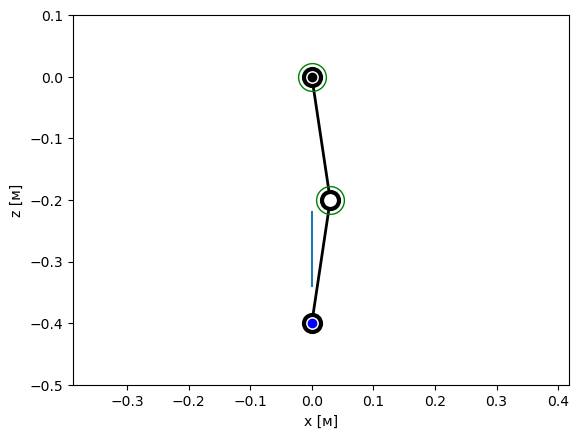

In [7]:
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[50:, 0], trajectory[50:, 2])
gm = get_preset_by_index_with_bounds(-1)
values = gm.generate_central_from_mutation_range()
graph = gm.get_graph(values)
draw_joint_point(graph,labels=2,draw_legend=False,draw_lines=True)
plt.show("trajectories.png")

In [8]:
pin.seed(1)
N_PROCESS = 8
population_size = 64
n_generations = 30
mechs = [0,2,6,8]
# for i in range(0,9):
result = {}
for i in mechs:
    pool = multiprocessing.Pool(N_PROCESS)
    runner = StarmapParallelization(pool.starmap)
    topology_index = i
    gm = get_preset_by_index_with_bounds(topology_index)
    # activate multiprocessing

    # create the problem for the current optimization
    problem = SingleCriterionProblem(gm, builder, reward_manager,
                                soft_constrain, elementwise_runner=runner, Actuator=builder.actuator['default'])
    algorithm = PSO(pop_size=population_size, save_history=True)

    saver = ProblemSaver(problem, f"imf_vertical\\filtered_topologies_40gen_64pop\\topology_{topology_index}", True)
    saver.save_nonmutable()
    optimizer = PymooOptimizer(problem, algorithm, saver)

    res = optimizer.run(
        True, **{
            "seed": 2,
            "termination": ("n_gen", n_generations),
            "verbose": True
        })
    ten_best = np.argsort(np.array(optimizer.history["F"]).flatten())[:10]
    result[i] = ten_best

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       64 |        - |       - |  0.9000 |  2.00000 |  2.00000 | -4.824422E-02 | -3.878662E-01
     2 |      128 |  0.34524 |       2 |  0.6206 |  2.03162 |  1.96838 | -1.706094E-01 | -4.357248E-01
     3 |      192 |  0.12299 |       3 |  0.4786 |  2.03119 |  1.98247 | -2.690689E-01 | -4.419874E-01
     4 |      256 | -3.8E-03 |       3 |  0.3976 |  2.02376 |  2.00143 | -3.502161E-01 | -4.526204E-01
     5 |      320 |  0.01136 |       3 |  0.4071 |  2.01083 |  2.01946 | -3.901789E-01 | -4.577858E-01
     6 |      384 |  0.01852 |       3 |  0.4116 |  1.99580 |  2.03196 | -4.107362E-01 | -4.624419E-01
     7 |      448 | -3.8E-03 |       3 |  0.3976 |  1.98240 |  2.04466 | -4.157095E-01 | -4.659940E-01
     8 |      512 |  0.00110 |       3 |  0.4007 |  1.96952 |  2.05149 | -4.186792E-01 | -4.695977E-01
     9 |      576 |  0.01380 |       3 |  0.4086 |  1.95997 |  2.06348 | 

In [9]:
print(result)

{0: array([1641, 1769, 1833, 1897, 1558, 1793, 1605, 1783, 1881, 1432],
      dtype=int64), 2: array([1883, 1889, 1862, 1914, 1919, 1822, 1880, 1860, 1866, 1894],
      dtype=int64), 6: array([1881, 1767, 1831, 1728, 1664, 1716, 1870, 1823, 1878, 1913],
      dtype=int64), 8: array([1917, 1884, 1548, 1740, 1774, 1531, 1403, 1872, 1467, 1876],
      dtype=int64)}
